In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import pickle
import nltk
nltk.download('punkt_tab')
from sklearn.metrics.pairwise import cosine_similarity

# Import custom pipeline
from pipeline import Pipeline

# For logging and warnings
import logging
import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# Define the corpus directory
corpus_directory = '/teamspace/studios/this_studio/storage/corpus'

# Initialize Pipeline
pipeline = Pipeline()

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


# Analysis 1 (Extraction): Embedding Model Selection

In [3]:
embedding_models = {
    'MiniLM': 'all-MiniLM-L6-v2',
    'MPNet': 'all-mpnet-base-v2'
}

In [3]:
# Load test queries
test_queries = [
    "What is the capital of France?",
    "Who was Abraham Lincoln?",
    "Who was Abraham Adams?",
    "How did Fillmore ascend to the presidency?",
    "What trail did Lincoln use a Farmers' Almanac in?",
    "What trial did Lincoln use a Farmers' Almanac in?",
]

# Function to run experiment for embedding models
def run_embedding_experiment(model_name):
    # Initialize Pipeline with the embedding model
    pipeline = Pipeline(embedding_model=model_name, reranker_type='hybrid')
    
    # Preprocess corpus (using default chunking strategy)
    start_time = time.time()
    pipeline.preprocess_corpus(corpus_directory)
    end_time = time.time()
    encoding_time = end_time - start_time
    
    # Save the index to avoid recomputation
    faiss_path = f'faiss_{model_name}.index'
    metadata_path = f'metadata_{model_name}.pkl'
    pipeline.save_index(faiss_path, metadata_path)
    
    # Evaluate retrieval performance
    retrieval_results = []
    for query in test_queries:
        neighbors = pipeline.search_neighbors(pipeline._Pipeline__encode(query), k=5)  # Get top retrieved chunks
        result = pipeline.generate_answer(query, neighbors, rerank=False)  # Generated answer
        retrieval_results.append({
            'query': query,
            'answer': result,  # Generated answer
            'context': neighbors  # Retrieved context
        })
    
    return {
        'encoding_time': encoding_time,
        'retrieval_results': retrieval_results
    }

def transformer_match_metric(generated_answers, reference_answers, model_name='all-MiniLM-L6-v2'):
    # Load the embedding model
    model = SentenceTransformer(model_name)
    
    # Encode both generated and reference answers
    generated_embeddings = model.encode(generated_answers)
    reference_embeddings = model.encode(reference_answers)
    
    # Compute cosine similarity for each pair of answers
    similarities = []
    for gen_emb, ref_emb in zip(generated_embeddings, reference_embeddings):
        similarity = cosine_similarity([gen_emb], [ref_emb])[0][0]
        similarities.append(similarity)
    
    # Return average similarity
    return np.mean(similarities), np.std(similarities)

In [ ]:
embedding_results = {}
for key, model_name in embedding_models.items():
    print(f"Running experiment for embedding model: {model_name}")
    result = run_embedding_experiment(model_name)
    embedding_results[key] = result

In [6]:
# Extract encoding times
encoding_times = {key: embedding_results[key]['encoding_time'] for key in embedding_results}

# Store retrieval results
retrieval_data = {}
for key in embedding_results:
    retrieval_data[key] = embedding_results[key]['retrieval_results']

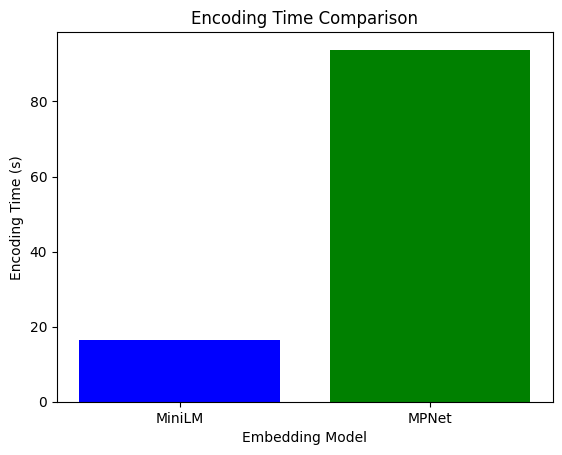

In [7]:
# Encoding Time Comparison
model_names = list(encoding_times.keys())
times = [encoding_times[model] for model in model_names]

plt.bar(model_names, times, color=['blue', 'green'])
plt.xlabel('Embedding Model')
plt.ylabel('Encoding Time (s)')
plt.title('Encoding Time Comparison')
plt.show()

In [8]:
from sentence_transformers import SentenceTransformer

# Compute Transformer Match Metric for each embedding model
transformer_scores = {}

for model in retrieval_data:
    print(f"Computing Transformer Match Metric for {model}...")
    generated_answers = [res['answer'] for res in retrieval_data[model]]
    reference_answers = [res['context'] for res in retrieval_data[model]]  # Use retrieved context
    
    avg_score, std_dev = transformer_match_metric(generated_answers, reference_answers, model_name=embedding_models[model])
    transformer_scores[model] = {'average_score': avg_score, 'std_dev': std_dev}

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Computing Transformer Match Metric for MiniLM...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2


Computing Transformer Match Metric for MPNet...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

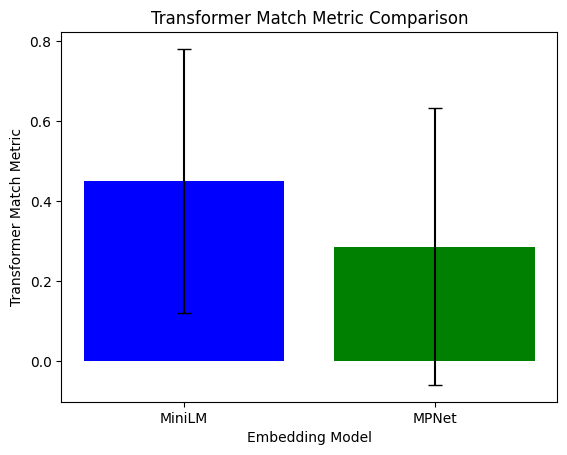

In [9]:
# Visualize Transformer Match Metric
avg_scores = [transformer_scores[model]['average_score'] for model in transformer_scores]
std_devs = [transformer_scores[model]['std_dev'] for model in transformer_scores]

plt.bar(model_names, avg_scores, yerr=std_devs, capsize=5, color=['blue', 'green'])
plt.xlabel('Embedding Model')
plt.ylabel('Transformer Match Metric')
plt.title('Transformer Match Metric Comparison')
plt.show()

In [10]:
# Print Generated Answers and Retrieved Contexts
for model in retrieval_data:
    print(f"\n===== Results for Embedding Model: {model} =====")
    for i, res in enumerate(retrieval_data[model]):
        print(f"\nQuery {i+1}: {res['query']}")
        print(f"Generated Answer: {res['answer']}")
        print(f"Retrieved Context: {' | '.join(res['context'])}")
        print("-" * 80)


===== Results for Embedding Model: MiniLM =====

Query 1: What is the capital of France?
Generated Answer: No context
Retrieved Context: After his term in the Senate, Monroe was appointed Minister to France from 1794 to 1796. His appointment there was made difficult as he had strong sympathies for the French Revolution, but dutifully maintained President Washington's strict policy of neutrality between Britiain and France. | In the late stages of the war he took personal control of negotiations with Germany, especially with the Fourteen Points and the Armistice. He went to Paris in 1919 to create the League of Nations and shape the Treaty of Versailles, with special attention on creating new nations out of defunct empires. | It also made several suggestions for specific disputes in Europe on the recommendation of Wilson's foreign policy advisor, Colonel Edward M. House, and his team of 150 advisors known as “The Inquiry.” The points were: Abolition of secret treaties Freedom of the se

In [11]:
# Print Encoding Times
print("=== Encoding Time Results ===")
for model_name, time_taken in encoding_times.items():
    print(f"Model: {model_name} - Encoding Time: {time_taken:.2f} seconds")
print("\n")

# Print Transformer Match Metric Results
print("=== Transformer Match Metric Results ===")
for model_name, metrics in transformer_scores.items():
    avg_score = metrics['average_score']
    std_dev = metrics['std_dev']
    print(f"Model: {model_name} - Average Score: {avg_score:.2f}, Standard Deviation: {std_dev:.2f}")

=== Encoding Time Results ===
Model: MiniLM - Encoding Time: 16.57 seconds
Model: MPNet - Encoding Time: 93.80 seconds


=== Transformer Match Metric Results ===
Model: MiniLM - Average Score: 0.45, Standard Deviation: 0.33
Model: MPNet - Average Score: 0.29, Standard Deviation: 0.35


# Analysis 2 (Extraction): Document Chunking Strategy

In [3]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import pickle
import nltk
nltk.download('punkt_tab')
from sklearn.metrics.pairwise import cosine_similarity

# Import custom pipeline
from pipeline import Pipeline

# For logging and warnings
import logging
import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO)

# Define the corpus directory
corpus_directory = '/teamspace/studios/this_studio/storage/corpus'

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Function to calculate cosine similarity for relevancy scoring
def calculate_relevancy(query_embedding, retrieved_embeddings):
    # Normalize embeddings
    query_embedding = query_embedding / np.linalg.norm(query_embedding)
    retrieved_embeddings = retrieved_embeddings / np.linalg.norm(retrieved_embeddings, axis=1, keepdims=True)
    
    # Compute cosine similarity
    similarities = cosine_similarity([query_embedding], retrieved_embeddings)
    return similarities[0]  # Return similarity scores for all retrieved embeddings


# Function to run experiment for chunking strategies with relevancy scoring
def run_chunking_experiment_with_relevancy(pipeline, chunking_strategy, fixed_length=None, overlap_size=2, queries=None):
    # Preprocess corpus with the specified chunking strategy
    start_time = time.time()
    pipeline.preprocess_corpus(
        corpus_directory,
        chunking_strategy=chunking_strategy,
        fixed_length=fixed_length,
        overlap_size=overlap_size
    )
    end_time = time.time()
    processing_time = end_time - start_time

    # Store processing time and number of chunks
    num_chunks = len(pipeline.context_data)
    
    # Evaluate relevancy impact using test queries
    relevancy_scores = []
    for query in queries:
        # Encode query
        query_embedding = pipeline.embedder.encode([query])
        
        # Retrieve neighbors
        neighbors = pipeline.search_neighbors(query_embedding, k=5)
        
        # Get embeddings for retrieved neighbors
        retrieved_embeddings = pipeline.embedder.encode(neighbors)
        
        # Calculate relevancy scores
        scores = calculate_relevancy(query_embedding[0], retrieved_embeddings)
        relevancy_scores.append(scores)
    
    # Average relevancy score
    avg_relevancy = np.mean([np.mean(scores) for scores in relevancy_scores])
    no_context_rate = len([scores for scores in relevancy_scores if len(scores) == 0]) / len(queries)
    
    return {
        'processing_time': processing_time,
        'num_chunks': num_chunks,
        'avg_relevancy': avg_relevancy,
        'no_context_rate': no_context_rate
    }

# Load test queries
test_queries = [
    "What is the capital of France?",
    "Who was Abraham Lincoln?",
    "Who was Abraham Adams?",
    "How did Fillmore ascend to the presidency?",
    "What trail did Lincoln use a Farmers' Almanac in?",
    "What trial did Lincoln use a Farmers' Almanac in?",
]

# Initialize the pipeline
pipeline = Pipeline(embedding_model='all-MiniLM-L6-v2', reranker_type='hybrid')

# Run experiments for sentence-based and fixed-length chunking
chunking_results = {}

print("Running experiment with sentence-based chunking...")
chunking_results['sentence'] = run_chunking_experiment_with_relevancy(
    pipeline,
    chunking_strategy='sentence',
    queries=test_queries
)

fixed_lengths = [50, 100, 150, 200]
overlap_sizes = [0, 5, 10, 15]

for fixed_length in fixed_lengths:
    for overlap_size in overlap_sizes:
        print(f"Running experiment with fixed-length chunking (fixed_length={fixed_length}, overlap_size={overlap_size})...")
        key = f"fixed_length_{fixed_length}_overlap_{overlap_size}"
        chunking_results[key] = run_chunking_experiment_with_relevancy(
            pipeline,
            chunking_strategy='fixed-length',
            fixed_length=fixed_length,
            overlap_size=overlap_size,
            queries=test_queries
        )

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


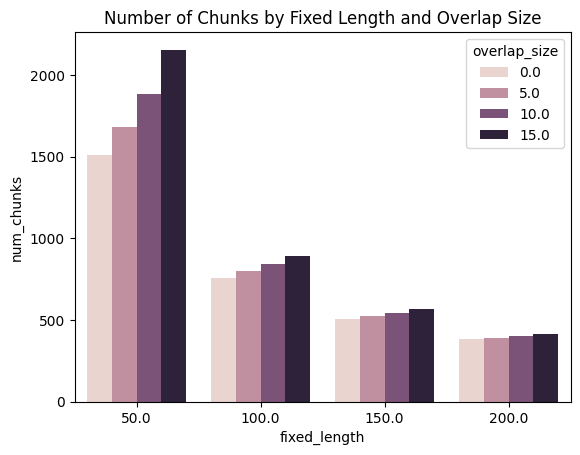

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


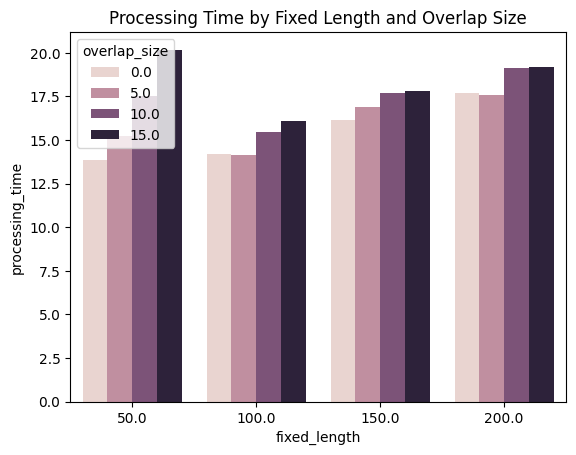

In [6]:
# Convert results to a DataFrame for analysis
import pandas as pd
df_results = pd.DataFrame(chunking_results)

# Save to CSV for reproducibility
df_results.to_csv('chunking_experiment_results.csv', index=False)

# Visualize Results
import seaborn as sns

# Plot for Number of Chunks
sns.barplot(data=df_results[df_results['strategy'] == 'fixed-length'], x='fixed_length', y='num_chunks', hue='overlap_size')
plt.title('Number of Chunks by Fixed Length and Overlap Size')
plt.show()

# Plot for Processing Time
sns.barplot(data=df_results[df_results['strategy'] == 'fixed-length'], x='fixed_length', y='processing_time', hue='overlap_size')
plt.title('Processing Time by Fixed Length and Overlap Size')
plt.show()

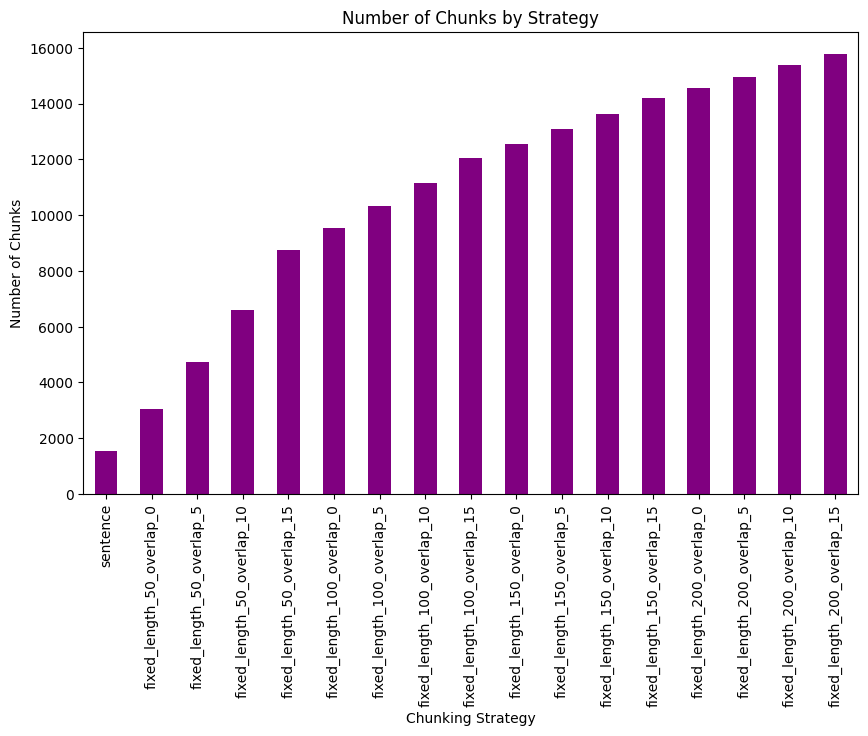

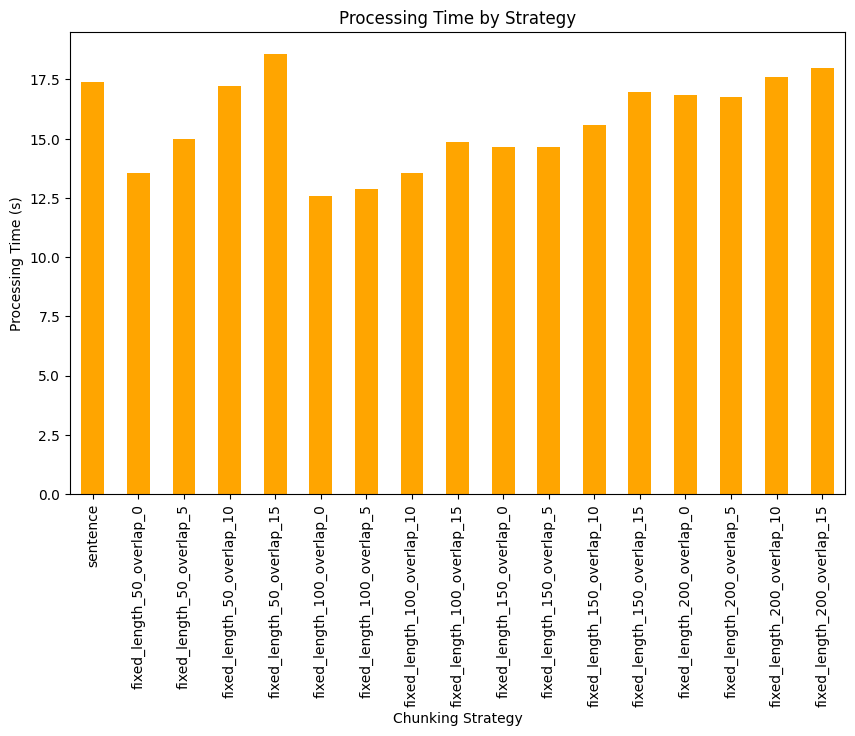

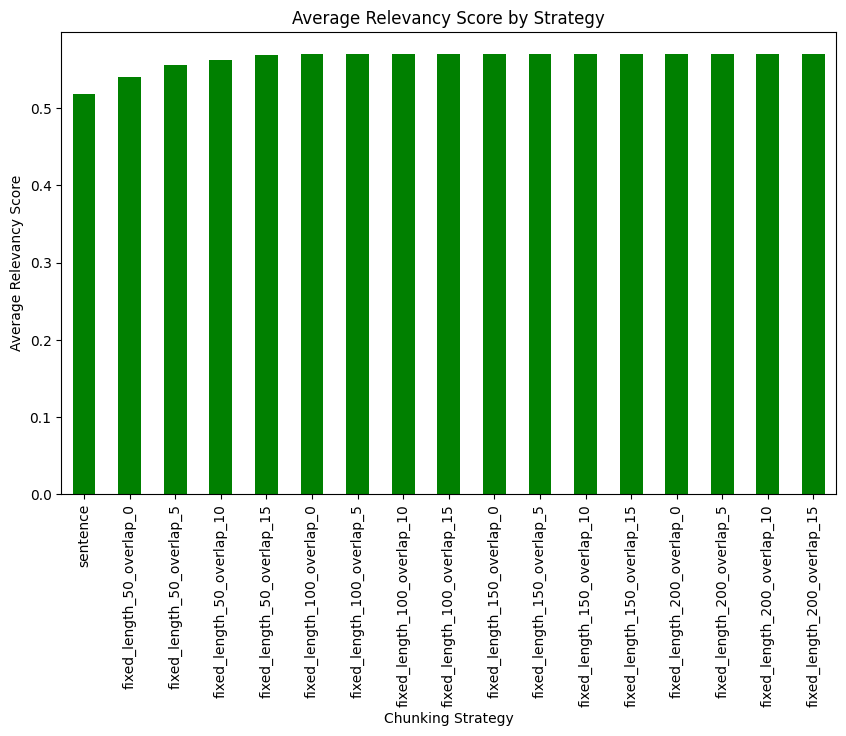

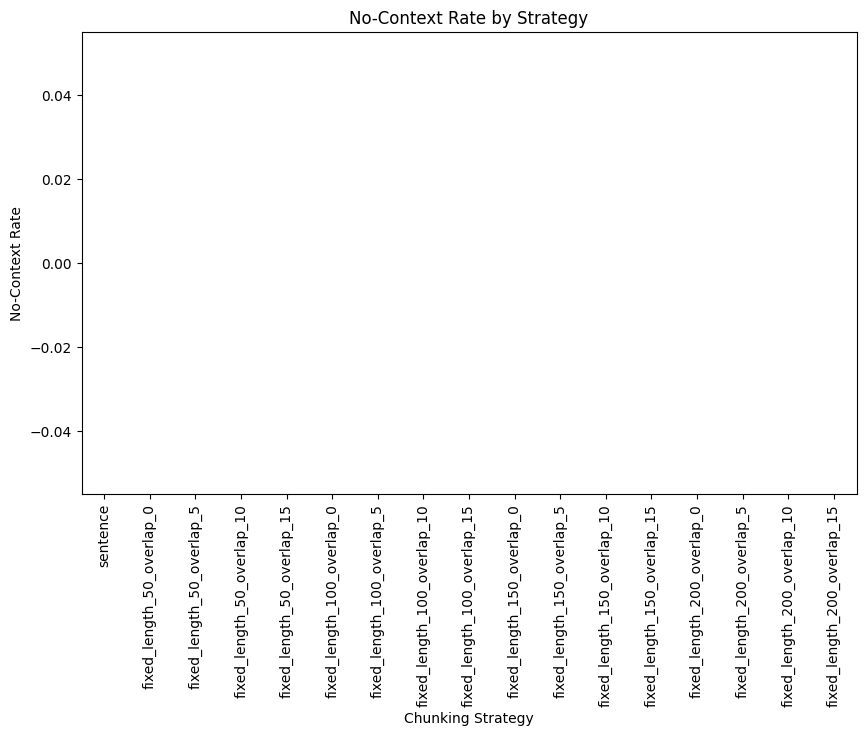

In [11]:
# Extract and visualize data
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame from results
results_df = pd.DataFrame.from_dict(chunking_results, orient='index')

# Plot number of chunks
results_df['num_chunks'].plot(kind='bar', figsize=(10, 6), color='purple', title='Number of Chunks by Strategy')
plt.ylabel('Number of Chunks')
plt.xlabel('Chunking Strategy')
plt.show()

# Plot processing times
results_df['processing_time'].plot(kind='bar', figsize=(10, 6), color='orange', title='Processing Time by Strategy')
plt.ylabel('Processing Time (s)')
plt.xlabel('Chunking Strategy')
plt.show()

# Plot relevancy scores
results_df['avg_relevancy'].plot(kind='bar', figsize=(10, 6), color='green', title='Average Relevancy Score by Strategy')
plt.ylabel('Average Relevancy Score')
plt.xlabel('Chunking Strategy')
plt.show()

# Plot no-context rate
results_df['no_context_rate'].plot(kind='bar', figsize=(10, 6), color='red', title='No-Context Rate by Strategy')
plt.ylabel('No-Context Rate')
plt.xlabel('Chunking Strategy')
plt.show()

In [12]:
# Print all stored results for chunking strategies
for strategy, data in chunking_results.items():
    print(f"Strategy: {strategy}")
    print(f"  - Number of Chunks: {data['num_chunks']}")
    print(f"  - Processing Time: {data['processing_time']} seconds")
    if 'relevancy_score' in data:
        print(f"  - Average Relevancy Score: {data['relevancy_score']}")
    print("-" * 30)

Strategy: sentence
  - Number of Chunks: 1531
  - Processing Time: 17.404760599136353 seconds
------------------------------
Strategy: fixed_length_50_overlap_0
  - Number of Chunks: 3042
  - Processing Time: 13.567712783813477 seconds
------------------------------
Strategy: fixed_length_50_overlap_5
  - Number of Chunks: 4720
  - Processing Time: 14.993138313293457 seconds
------------------------------
Strategy: fixed_length_50_overlap_10
  - Number of Chunks: 6606
  - Processing Time: 17.209420919418335 seconds
------------------------------
Strategy: fixed_length_50_overlap_15
  - Number of Chunks: 8761
  - Processing Time: 18.57424521446228 seconds
------------------------------
Strategy: fixed_length_100_overlap_0
  - Number of Chunks: 9520
  - Processing Time: 12.57348918914795 seconds
------------------------------
Strategy: fixed_length_100_overlap_5
  - Number of Chunks: 10317
  - Processing Time: 12.894462585449219 seconds
------------------------------
Strategy: fixed_leng

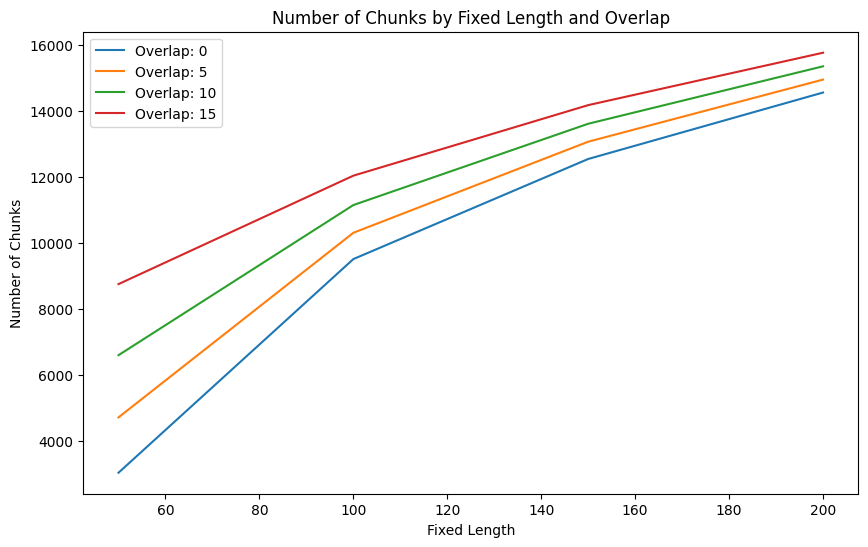

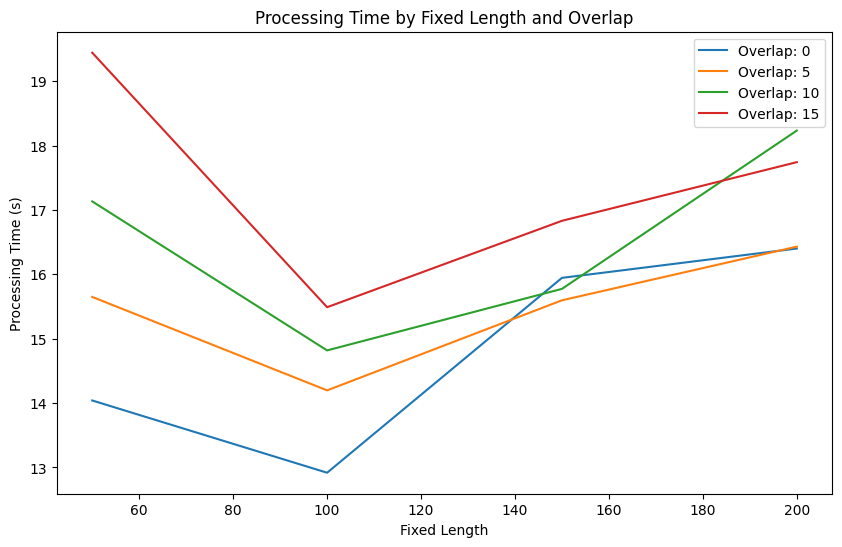

In [9]:
# Results Visualization
import pandas as pd

# Convert results into a DataFrame for analysis
chunking_df = pd.DataFrame.from_dict(chunking_results, orient='index')
chunking_df['strategy'] = chunking_df.index
chunking_df[['strategy_type', 'fixed_length', 'overlap_size']] = chunking_df['strategy'].str.extract(r'(sentence|fixed)_(\d+)?_?overlap_?(\d+)?')
chunking_df['fixed_length'] = pd.to_numeric(chunking_df['fixed_length'], errors='coerce')
chunking_df['overlap_size'] = pd.to_numeric(chunking_df['overlap_size'], errors='coerce')

# Plot results for analysis
import matplotlib.pyplot as plt

# Number of chunks
plt.figure(figsize=(10, 6))
for overlap in overlap_sizes:
    subset = chunking_df[chunking_df['overlap_size'] == overlap]
    plt.plot(subset['fixed_length'], subset['num_chunks'], label=f'Overlap: {overlap}')
plt.title('Number of Chunks by Fixed Length and Overlap')
plt.xlabel('Fixed Length')
plt.ylabel('Number of Chunks')
plt.legend()
plt.show()

# Processing Time
plt.figure(figsize=(10, 6))
for overlap in overlap_sizes:
    subset = chunking_df[chunking_df['overlap_size'] == overlap]
    plt.plot(subset['fixed_length'], subset['processing_time'], label=f'Overlap: {overlap}')
plt.title('Processing Time by Fixed Length and Overlap')
plt.xlabel('Fixed Length')
plt.ylabel('Processing Time (s)')
plt.legend()
plt.show()

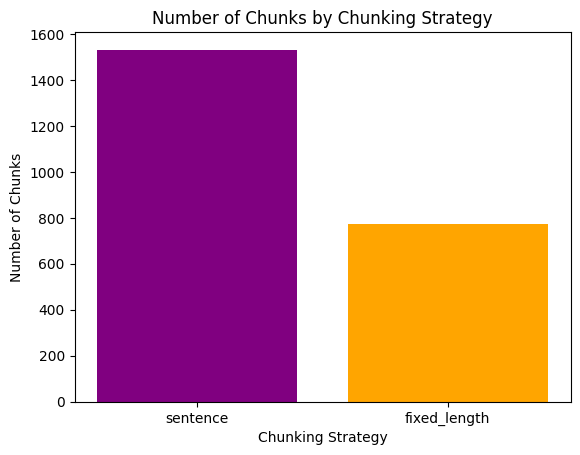

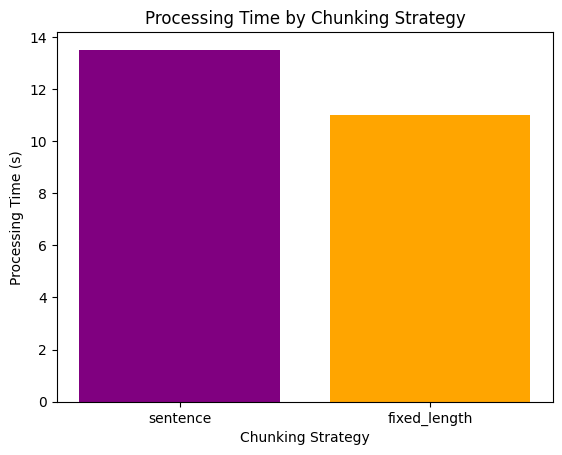

In [12]:
# Plot number of chunks
plt.bar(chunking_strategies, num_chunks, color=['purple', 'orange'])
plt.xlabel('Chunking Strategy')
plt.ylabel('Number of Chunks')
plt.title('Number of Chunks by Chunking Strategy')
plt.show()

# Plot processing times
plt.bar(chunking_strategies, processing_times, color=['purple', 'orange'])
plt.xlabel('Chunking Strategy')
plt.ylabel('Processing Time (s)')
plt.title('Processing Time by Chunking Strategy')
plt.show()

# Analysis 3 (Retrieval): Embedding Dimensionality

In [ ]:
# Create an instance of the Pipeline
pipeline = Pipeline(embedding_model='all-MiniLM-L6-v2', reranker_type='hybrid')

# Preprocess and encode the corpus
pipeline.preprocess_corpus(
    corpus_directory=corpus_directory, 
    chunking_strategy='sentence', 
    overlap_size=2
)

# Save the index for later use (optional)
pipeline.save_index(faiss_path='faiss_all-MiniLM-L6-v2.index', metadata_path='metadata_all-MiniLM-L6-v2.pkl')

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import time
import faiss
import matplotlib.pyplot as plt

def fit_pca(embeddings, target_dim):
    pca = PCA(n_components=target_dim)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings, pca

def apply_pca(pca, embeddings):
    return pca.transform(embeddings)

# Retrieve encoded corpus embeddings
corpus_texts = pipeline.context_data  # Retrieve the chunks
corpus_embeddings = pipeline.embedder.encode(corpus_texts)  # Encode them into embeddings

# Dimensions to test for PCA
dimensions_to_test = [128, 64, 32]  # Target embedding dimensions

# Variables to store results for plotting
retrieval_times = []
relevance_scores = []

# Loop through target dimensions for testing
for target_dim in dimensions_to_test:
    print(f"Testing with {target_dim}-dimensional embeddings")
    
    # Fit PCA on the corpus embeddings
    reduced_corpus_embeddings, pca = fit_pca(corpus_embeddings, target_dim)
    
    # Create a FAISS index for the reduced embeddings
    index = faiss.IndexFlatL2(target_dim)
    index.add(reduced_corpus_embeddings)
    
    total_relevance = 0
    total_time = 0

    # Load test queries
    test_queries = [
        "What is the capital of France?",
        "Who was Abraham Lincoln?",
        "Who was Abraham Adams?",
        "How did Fillmore ascend to the presidency?",
        "What trail did Lincoln use a Farmers' Almanac in?",
        "What trial did Lincoln use a Farmers' Almanac in?",
    ]
    
    # Test retrieval for queries
    for query in test_queries:
        # Encode the query string into embeddings
        query_embedding = pipeline.embedder.encode([query])  # Encode query string into vector

        # Apply pre-fitted PCA to reduce the query embedding
        query_embedding_reduced = apply_pca(pca, query_embedding)

        # Perform FAISS search
        start_time = time.time()
        distances, indices = index.search(query_embedding_reduced, k=5)
        end_time = time.time()

        total_time += (end_time - start_time)

        # Retrieve metadata for relevance calculation
        retrieved_metadata = [
            {"text": pipeline.context_data[i]}  # Wrap each string in a dictionary with a "text" key
            for i in indices[0]
            if i < len(pipeline.context_data)
        ]

        # Calculate relevance using query embedding
        relevance = calculate_relevance(query_embedding[0], retrieved_metadata)  # Use the un-reduced original embedding
        total_relevance += np.mean(relevance)

    # Store results for plotting
    avg_time = total_time / len(test_queries)
    avg_relevance = total_relevance / len(test_queries)
    retrieval_times.append(avg_time)
    relevance_scores.append(avg_relevance)

    print(f"Avg retrieval time for {target_dim} dimensions: {avg_time:.4f} seconds")
    print(f"Avg relevance score for {target_dim} dimensions: {avg_relevance:.4f}")

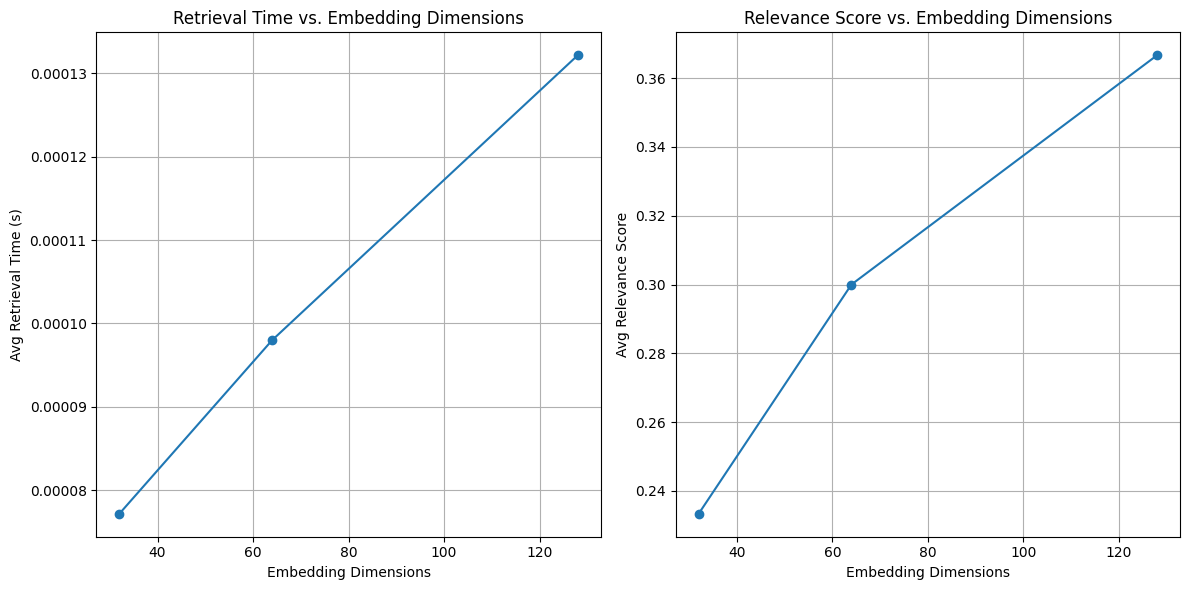

In [56]:
# Plotting the results
plt.figure(figsize=(12, 6))

# Plot retrieval times
plt.subplot(1, 2, 1)
plt.plot(dimensions_to_test, retrieval_times, marker='o')
plt.title('Retrieval Time vs. Embedding Dimensions')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Avg Retrieval Time (s)')
plt.grid()

# Plot relevance scores
plt.subplot(1, 2, 2)
plt.plot(dimensions_to_test, relevance_scores, marker='o')
plt.title('Relevance Score vs. Embedding Dimensions')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Avg Relevance Score')
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()

# Analysis 5 (Generation): Model Size & Temperature vs. Response Time & Answer Quality

In [1]:
import os
import sys
import json
import numpy as np
from pipeline import Pipeline
from IPython.display import display, Markdown

In [2]:
# Define the corpus directory
corpus_directory = '/teamspace/studios/this_studio/storage/corpus'

# Initialize Pipeline
pipeline = Pipeline()

In [ ]:
pipeline.preprocess_corpus(corpus_directory)

In [27]:
import time
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from question_answering import QA_Generator

# Define test configurations
models = ["mistral-small-latest", "mistral-large-latest"]
temperatures = [0.1, 0.5]
queries = [
    ("What is the capital of France?", ["Paris is the capital of France."]),
    ("How did Fillmore ascend to the presidency?", ["Millard Fillmore became president after the death of Zachary Taylor."]),
    ("What trail did Lincoln use a Farmers' Almanac in?", ["Lincoln used a Farmers' Almanac during the trial of William Armstrong."]),
    ("Who was Abraham Adams?", ["No context."])  # Deliberately ambiguous query
]

# Initialize the Sentence Transformer for quality assessment
transformer_model = SentenceTransformer('all-MiniLM-L6-v2')

# Initialize results list
results = []

# Function to compute Transformer Match Metric
def transformer_match_metric(generated_answers, reference_answers, model=transformer_model):
    generated_embeddings = model.encode(generated_answers)
    reference_embeddings = model.encode(reference_answers)
    similarities = [
        cosine_similarity([gen_emb], [ref_emb])[0][0]
        for gen_emb, ref_emb in zip(generated_embeddings, reference_embeddings)
    ]
    return round(sum(similarities) / len(similarities), 2)  # Average similarity

# Run tests
for model in models:
    for temp in temperatures:
        for query, context in queries:
            generator = QA_Generator(generator_model=model, temperature=temp)
            
            # Measure response time
            start_time = time.time()
            answer = generator.generate_answer(query, context)
            response_time = (time.time() - start_time) * 1000  # Response time in ms
            
            # Compute quality score
            quality_score = transformer_match_metric([answer], context)
            
            # Store results
            results.append({
                "Model": model,
                "Temperature": temp,
                "Query": query,
                "Context": " | ".join(context),
                "Answer": answer,
                "Response Time (ms)": response_time,
                "Quality Score": quality_score
            })

# Convert results to DataFrame
df = pd.DataFrame(results)
df.to_csv("mistral_model_analysis.csv", index=False)  # Save results for further analysis

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO:httpx:HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"


[ChatCompletionChoice(index=0, message=AssistantMessage(content='Paris is the capital of France.', tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"


[ChatCompletionChoice(index=0, message=AssistantMessage(content='Millard Fillmore ascended to the presidency upon the death of Zachary Taylor.', tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"


[ChatCompletionChoice(index=0, message=AssistantMessage(content="Lincoln used a Farmers' Almanac during the trial of William Armstrong.", tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"


[ChatCompletionChoice(index=0, message=AssistantMessage(content='No context.', tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"


[ChatCompletionChoice(index=0, message=AssistantMessage(content='Paris is the capital of France.', tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"


[ChatCompletionChoice(index=0, message=AssistantMessage(content='Millard Fillmore ascended to the presidency upon the death of Zachary Taylor.', tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"


[ChatCompletionChoice(index=0, message=AssistantMessage(content="Lincoln used a Farmers' Almanac during the trial of William Armstrong.", tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"


[ChatCompletionChoice(index=0, message=AssistantMessage(content='No context', tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"


[ChatCompletionChoice(index=0, message=AssistantMessage(content='The capital of France is Paris.', tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"


[ChatCompletionChoice(index=0, message=AssistantMessage(content='Millard Fillmore ascended to the presidency after the death of Zachary Taylor.', tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"


[ChatCompletionChoice(index=0, message=AssistantMessage(content="Lincoln used a Farmers' Almanac during the trial of William Armstrong.", tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"


[ChatCompletionChoice(index=0, message=AssistantMessage(content='No context.', tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"


[ChatCompletionChoice(index=0, message=AssistantMessage(content='The capital of France is Paris.', tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"


[ChatCompletionChoice(index=0, message=AssistantMessage(content='Millard Fillmore ascended to the presidency after the death of Zachary Taylor.', tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"


[ChatCompletionChoice(index=0, message=AssistantMessage(content="Lincoln used a Farmers' Almanac during the trial of William Armstrong.", tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.mistral.ai/v1/chat/completions "HTTP/1.1 200 OK"


[ChatCompletionChoice(index=0, message=AssistantMessage(content='No context.', tool_calls=None, prefix=False, role='assistant'), finish_reason='stop')]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

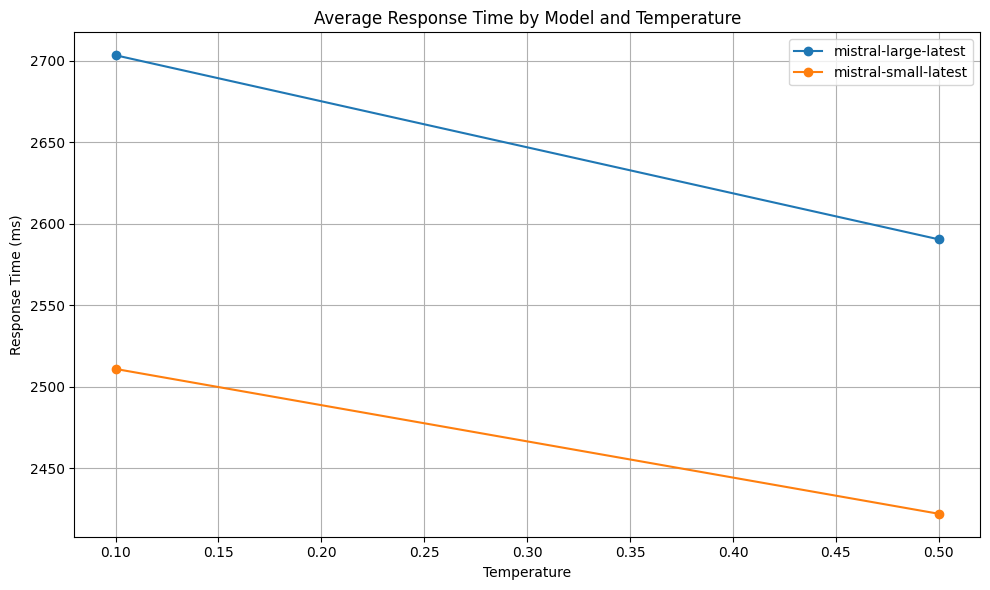

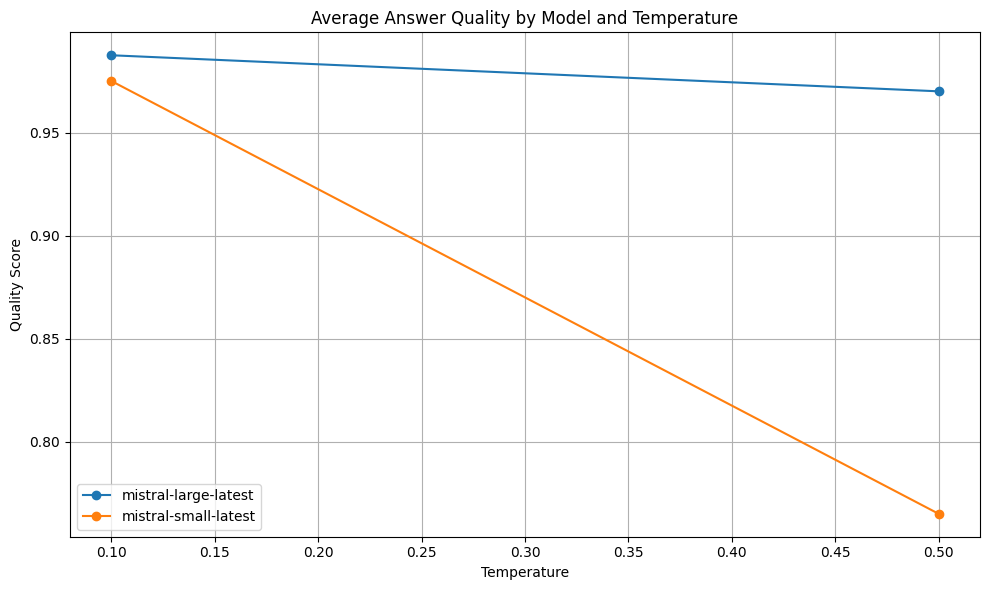

In [26]:
# Load the CSV
df = pd.read_csv("mistral_model_analysis.csv")

# Calculate average response time
avg_response_time = df.groupby(["Model", "Temperature"])["Response Time (ms)"].mean().reset_index()

plt.figure(figsize=(10, 6))
for model in avg_response_time["Model"].unique():
    subset = avg_response_time[avg_response_time["Model"] == model]
    plt.plot(subset["Temperature"], subset["Response Time (ms)"], label=model, marker='o')
plt.title("Average Response Time by Model and Temperature")
plt.xlabel("Temperature")
plt.ylabel("Response Time (ms)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate average quality score
avg_quality_score = df.groupby(["Model", "Temperature"])["Quality Score"].mean().reset_index()

plt.figure(figsize=(10, 6))
for model in avg_quality_score["Model"].unique():
    subset = avg_quality_score[avg_quality_score["Model"] == model]
    plt.plot(subset["Temperature"], subset["Quality Score"], label=model, marker='o')
plt.title("Average Answer Quality by Model and Temperature")
plt.xlabel("Temperature")
plt.ylabel("Quality Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()